## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob                       # file pattern matching
import PIL.Image as Image         # image loading
from tqdm.notebook import tqdm    # progress bars (Jupyter)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms   # data transform/augmentation
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")        # GPU available
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     # set computer device

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# custom dataset class for Hotdog/NotHotDog
class Hotdog_NotHotdog(torch.utils.data.Dataset):

    def __init__(self, train, transform, data_path='/content/drive/MyDrive/DTU/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')       # select subfolder: train/ and test/
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]     # find class folders inside (hotdog/nothotdog)
        image_classes.sort()            # consistent order
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')        # all image file paths

    def __len__(self):
        return len(self.image_paths)      # total number of images

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]            # pick image path
        image = Image.open(image_path)                # load image (PIL)
        c = os.path.split(os.path.split(image_path)[0])[1]    # get folder name (class)
        y = self.name_to_label[c]                     # numeric label
        X = self.transform(image)                     # apply transformations
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [5]:
size = 128

# resize all images to 128x128, then convert to tensor
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])

batch_size = 64

# training dataset -> custom Dataset with transform
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)

# training DataLoader → 64 images per batch, shuffle each epoch, use 3 workers (Colab suggests 2)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# Get one batch from train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

print("Batch size:", images.size(0))

print("Image shape:", images.size())  # (batch_size, channels, height, width)

Batch size: 64
Image shape: torch.Size([64, 3, 128, 128])


Let's look at some images from our data

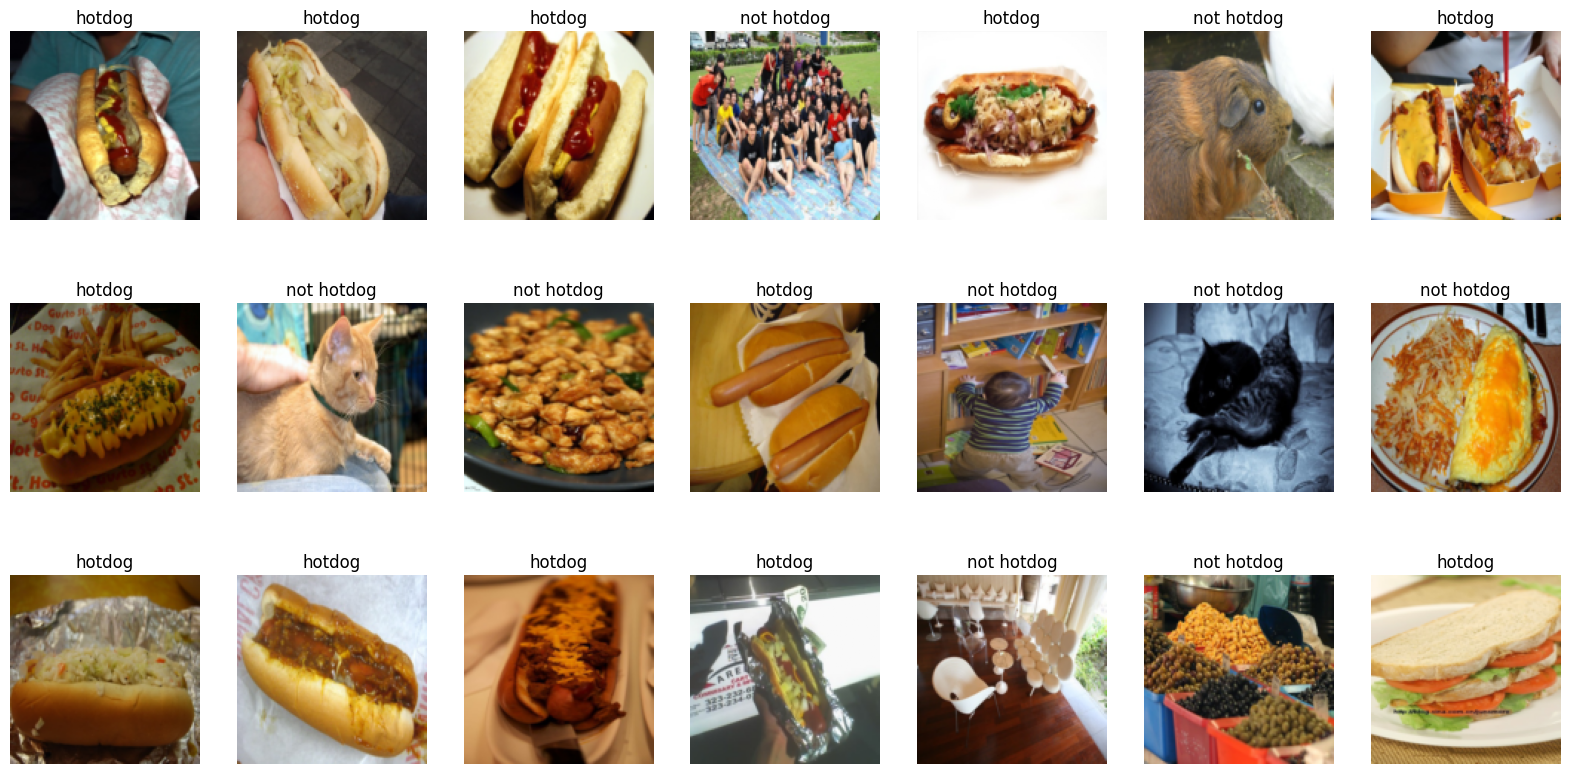

In [7]:
images, labels = next(iter(train_loader))     # get one batch of images+labels
plt.figure(figsize=(20,10))

for i in range(21):                           # show first 21 images
    plt.subplot(3,7,i+1)

    # convert tensor (C,H,W) → numpy (H,W,C) for matplotlib
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    # title: map numeric label → class name
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now **create a model** and train it!


In [8]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

DATA_PATH = "/content/drive/MyDrive/DTU/hotdog_nothotdog"
IMG_SIZE = 128
BATCH = 64
WORKERS = 2
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')

class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.features = nn.Sequential(
        # 3xHxW -> 32xHxW
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),

        # 32 -> 64
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),

        # 64 -> 128
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),

        # 128 -> 256
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),

        # 256 -> 512
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),
    )
    self.gap = nn.AdaptiveAvgPool2d(1)        # (8, 512, 1, 1)
    self.fc = nn.Sequential(                  # logits, no Softmax
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(256, 2),
    )

  def forward(self, x):
    x = self.features(x)            # conv blocks
    x = self.gap(x)                 # global average pooling (GAP)
    x = torch.flatten(x, 1)         # (8, 512)
    x = self.fc(x)                  # (8, 2)
    return x

  def convolutional(self, x):
    return self.features(x)         # returns feature maps

**Training**

In [9]:
print(trainset.name_to_label)

{'hotdog': 0, 'nothotdog': 1}


In [10]:
model = Network().to(device)                                    # my CNN (5 conv blocks + GAP + FC)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)     # this is the other one

criterion = nn.CrossEntropyLoss()                               # small smoothing helps, you can put label_smoothing=0.3

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
# scaler = torch.amp.GradScaler('cuda')                           # AMP scaler for faster, safer fp16

train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(10),
    T.ColorJitter(0.1,0.1,0.1),
    T.ToTensor(),
    T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),     # mean and std_dev are per-channel statistics of the ImageNet dataset
])
test_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

# your Dataset class
trainset = Hotdog_NotHotdog(train=True, transform=train_tf, data_path=DATA_PATH)
testset = Hotdog_NotHotdog(train=False, transform=test_tf, data_path=DATA_PATH)

train_loader = DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=WORKERS)
test_loader = DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=WORKERS)

print("Size of training dataset:", len(trainset))
print("Size of test dataset:", len(testset))


# Training function
def train(model, optimizer, num_epochs=7):
    # define weights once (we can also penalize more a choice)
    class_weights = torch.tensor([1.0, 1.0], device=device)

    out_dict = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': []}
    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_loss = 0.0

        # one bar for batches, with an epoch label
        for data, target in tqdm(train_loader, total=len(train_loader), leave=False):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            logits = model(data)
            loss = F.cross_entropy(logits, target, weight=class_weights)      # weighted cross-entropy

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            predicted = logits.argmax(1)
            train_correct += (logits.argmax(1) == target).sum().item()

        # Evaluation
        model.eval()
        test_correct = 0
        test_loss = 0.0

        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)

                loss = F.cross_entropy(output, target, weight=class_weights)

                test_loss += loss.item() * data.size(0)
                probs = torch.softmax(output, dim=1)
                predicted = probs.argmax(1)
                test_correct += (output.argmax(1) == target).sum().item()

                # Save incorrect indices
                incorrect = (predicted != target).nonzero(as_tuple=True)[0]
                start_idx = batch_idx * batch_size

        train_loss /= len(trainset)
        test_loss /= len(testset)
        train_acc  = train_correct/len(trainset)
        test_acc  = test_correct/len(testset)

        out_dict['train_loss'].append(train_loss)
        out_dict['test_loss'].append(test_loss)
        out_dict['train_acc'].append(train_acc)
        out_dict['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.1f}% "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.1f}%")
    return out_dict

Size of training dataset: 2047
Size of test dataset: 1862


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/12 Train Loss: 0.5674 | Train Acc: 71.2% Test Loss: 0.5510 | Test Acc: 73.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/12 Train Loss: 0.4707 | Train Acc: 79.0% Test Loss: 0.4937 | Test Acc: 76.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/12 Train Loss: 0.4585 | Train Acc: 79.5% Test Loss: 0.5279 | Test Acc: 76.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/12 Train Loss: 0.4284 | Train Acc: 81.0% Test Loss: 0.4824 | Test Acc: 77.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/12 Train Loss: 0.4095 | Train Acc: 81.4% Test Loss: 0.4406 | Test Acc: 79.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/12 Train Loss: 0.3934 | Train Acc: 82.7% Test Loss: 0.8295 | Test Acc: 70.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/12 Train Loss: 0.3871 | Train Acc: 82.8% Test Loss: 0.4771 | Test Acc: 78.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/12 Train Loss: 0.3686 | Train Acc: 84.1% Test Loss: 0.4204 | Test Acc: 81.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/12 Train Loss: 0.3550 | Train Acc: 84.9% Test Loss: 0.4979 | Test Acc: 79.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/12 Train Loss: 0.3626 | Train Acc: 84.9% Test Loss: 0.4403 | Test Acc: 81.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/12 Train Loss: 0.3346 | Train Acc: 86.1% Test Loss: 0.4739 | Test Acc: 78.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/12 Train Loss: 0.3434 | Train Acc: 85.6% Test Loss: 0.4252 | Test Acc: 81.1%


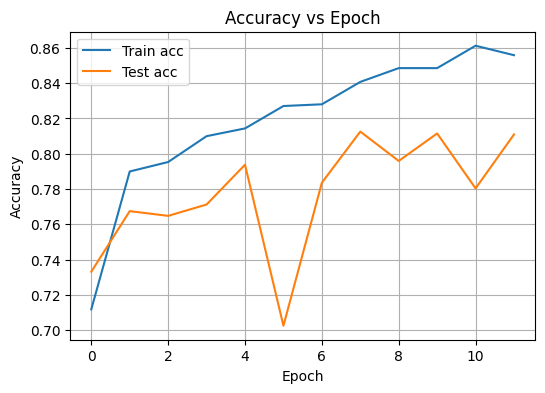

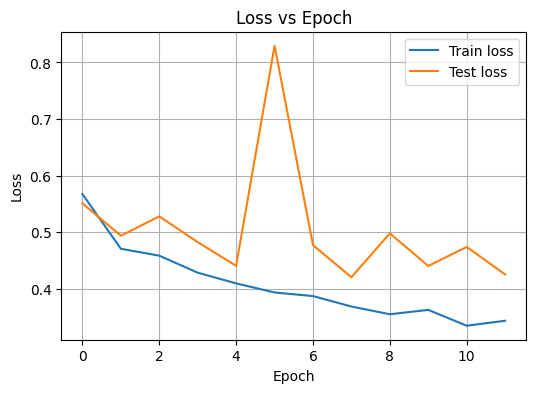

In [11]:
# Run + Plots
out_dict = train(model, optimizer, num_epochs=12)

plt.figure(figsize=(6,4))
plt.plot(out_dict['train_acc'], label="Train acc")
plt.plot(out_dict['test_acc'],  label="Test acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy");
plt.legend();
plt.grid(True);
plt.title("Accuracy vs Epoch");
plt.show()

plt.figure(figsize=(6,4))
plt.plot(out_dict['train_loss'], label="Train loss")
plt.plot(out_dict['test_loss'],  label="Test loss")
plt.xlabel("Epoch"); plt.ylabel("Loss");
plt.legend();
plt.grid(True);
plt.title("Loss vs Epoch");
plt.show()

**Some STATS**


TRAIN accuracy: 85.39%


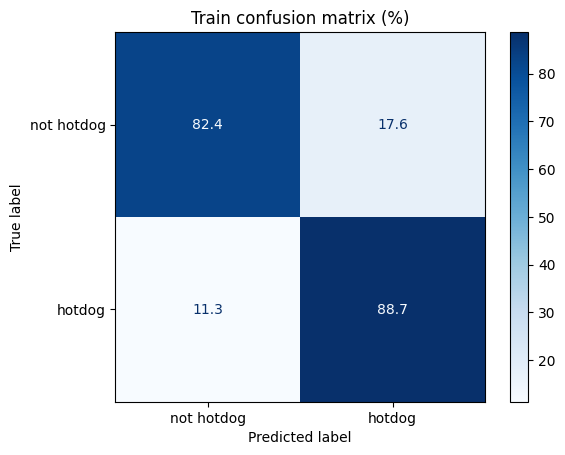


TEST accuracy: 81.10%


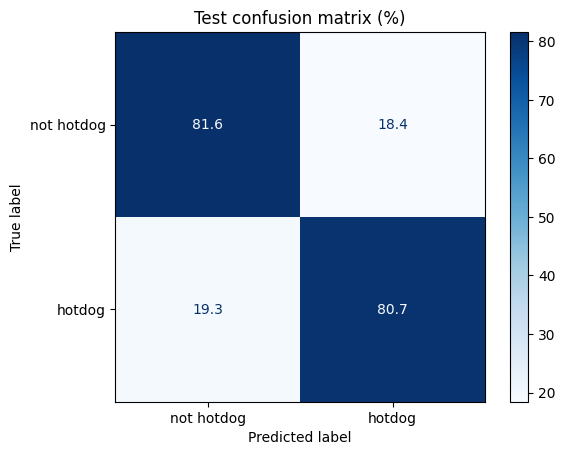

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

@torch.no_grad()
def evaluate(model, loader, split="test"):
    model.eval()
    all_preds, all_targets = [], []

    for data, target in loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    cm_percent = cm.astype("float") / cm.sum(axis=1)[:, None] * 100

    acc = (cm.diagonal().sum() / cm.sum()) * 100
    print(f"\n{split.upper()} accuracy: {acc:.2f}%")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                                  display_labels=["not hotdog", "hotdog"])
    disp.plot(cmap="Blues", values_format=".1f")
    plt.title(f"{split.capitalize()} confusion matrix (%)")
    plt.show()

# Run on train and test
evaluate(model, train_loader, split="train")
evaluate(model, test_loader, split="test")


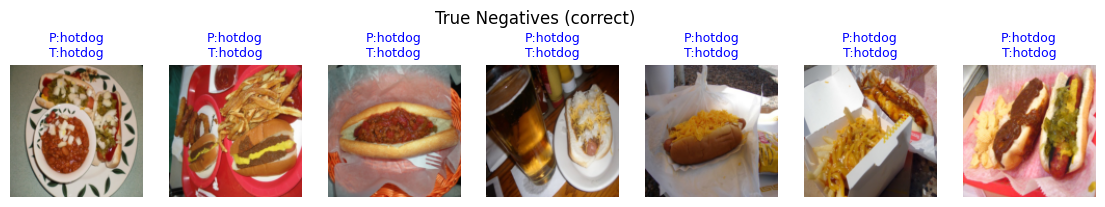

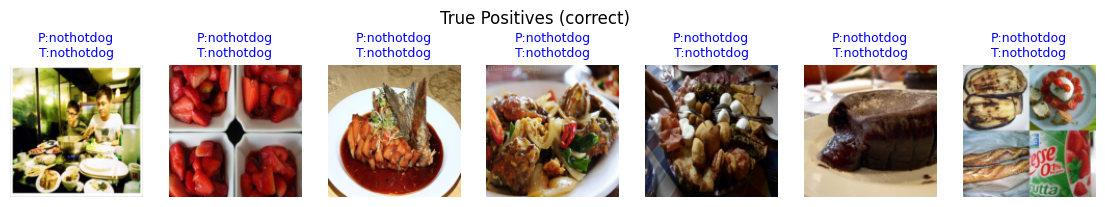

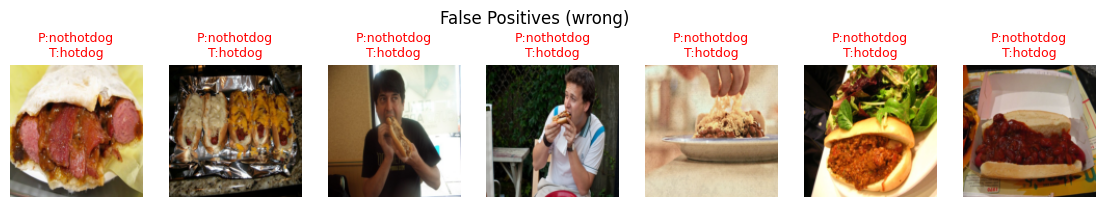

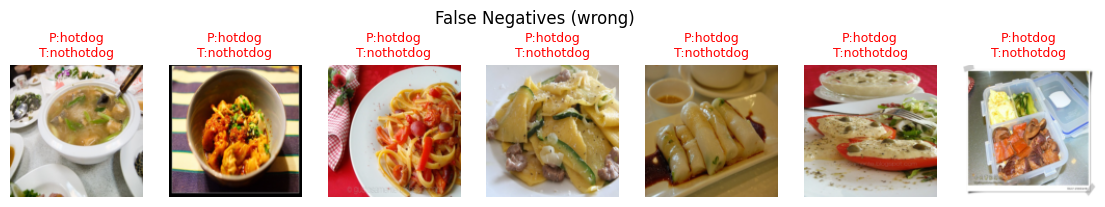

In [13]:
import torch
import matplotlib.pyplot as plt

def get_idx_to_class(ds):
    # reconstruct the mapping from numeric indices -> class names
    if hasattr(ds, "class_to_idx") and isinstance(ds.class_to_idx, dict):
        return {v:k for k,v in ds.class_to_idx.items()}
    if hasattr(ds, "classes"):
        return {i:n for i,n in enumerate(ds.classes)}
    return {0:"hotdog", 1:"nothotdog"}

@torch.no_grad()    # is a decorator (equivalent to using with torch.no_grad(): as a context manager) that turns off gradient tracking
                    # for everything executed inside the function. PyTorch will not build a computation graph or store intermediates for backpropagation.

def show_confusion_examples(model, loader, split="test", per_bucket=7):
    model.eval()
    ds = loader.dataset
    idx_to_class = get_idx_to_class(ds)

    # Buckets to hold example images by outcome type
    TN, TP, FP, FN = [], [], [], []   # store (img, pred, true)

    # iterate over the dataloader once (evaluation pass)
    for data, target in loader:
        data, target = data.to(device), target.to(device)

        # forward pass
        logits = model(data)
        pred = logits.argmax(1)     # predict class indices

        # sort each sample into the appropriate buvket until each bucket has 'per_backet' examples
        for i in range(len(target)):
            item = (data[i].cpu(), pred[i].item(), target[i].item())
            t, p = item[2], item[1]
            if   t == 0 and p == 0 and len(TN) < per_bucket: TN.append(item)
            elif t == 1 and p == 1 and len(TP) < per_bucket: TP.append(item)
            elif t == 0 and p == 1 and len(FP) < per_bucket: FP.append(item)
            elif t == 1 and p == 0 and len(FN) < per_bucket: FN.append(item)

        # stop early if all filled
        if all(len(b) >= per_bucket for b in (TN,TP,FP,FN)):
            break

    # Reverse ImageNet normalization to display images nicely
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    def unnorm(img):
      return (img * std + mean).clamp(0,1)

    # to draw a single row of images with colored titles
    def show_row(examples, title, color):
        if not examples:
            print(f"{title}: no examples.")
            return
        n = len(examples)
        plt.figure(figsize=(2*n, 2.5))
        for i, (img, p, t) in enumerate(examples):
            plt.subplot(1, n, i+1)
            plt.imshow(unnorm(img).permute(1,2,0))
            plt.axis("off")
            # title shows predicted and true class names; color encodes correctness type
            plt.title(f"P:{idx_to_class.get(p,p)}\nT:{idx_to_class.get(t,t)}", color=color, fontsize=9)
        plt.suptitle(title, fontsize=12)
        plt.show()

    # Correct in blue (TN/TP), Wrong in red (FP/FN)
    show_row(TN, f"True Negatives (correct)", color="blue")
    show_row(TP, f"True Positives (correct)", color="blue")
    show_row(FP, f"False Positives (wrong)", color="red")
    show_row(FN, f"False Negatives (wrong)", color="red")

# Use it
show_confusion_examples(model, test_loader, split="test", per_bucket=7)
